# Informatyka systemów złożonych – laboratorium 3
## Mateusz Kocot

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

import time

from ba import BA
from ba_remover import BARemover

# Zadanie 1. Model rosnącego grafu scale-free: Barabasi-Albert (BA)

Elapsed 0.01 s


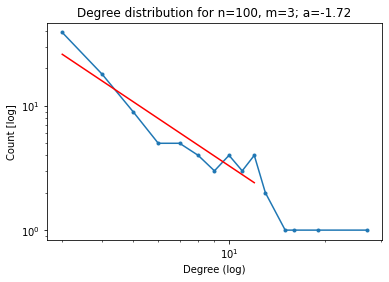

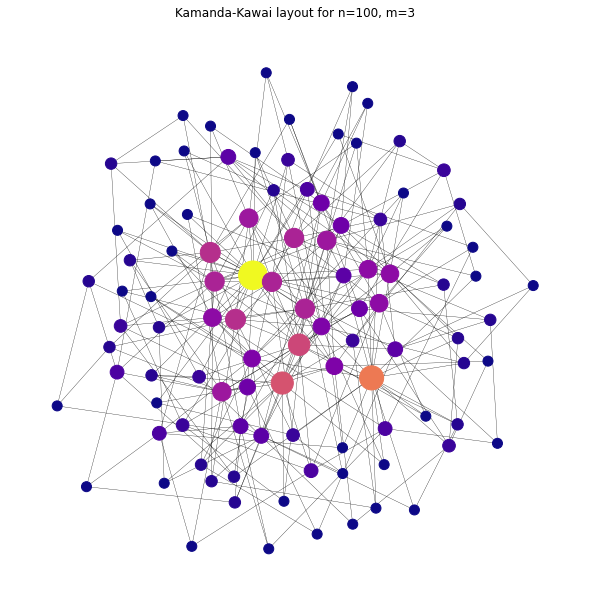

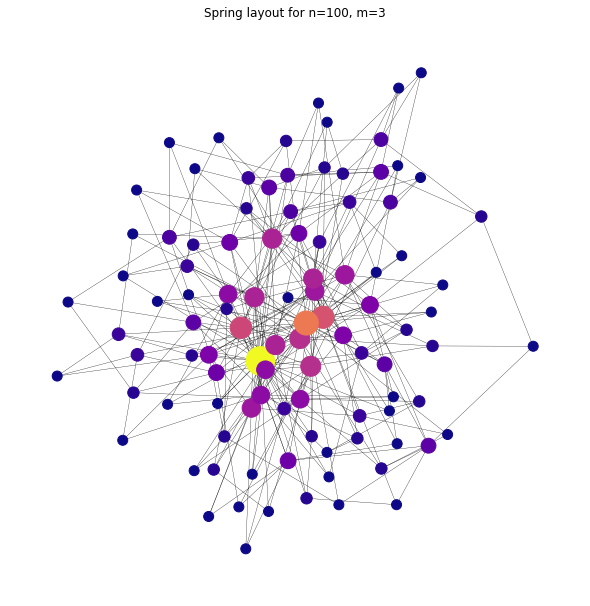

Elapsed 0.04 s


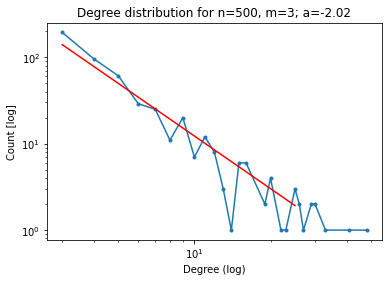

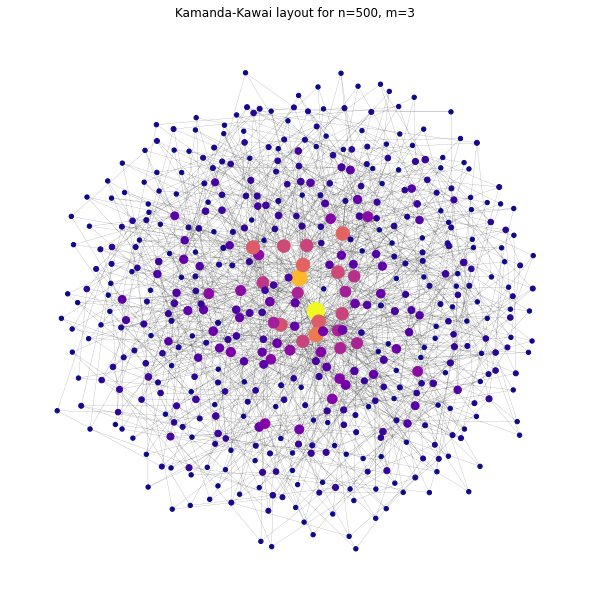

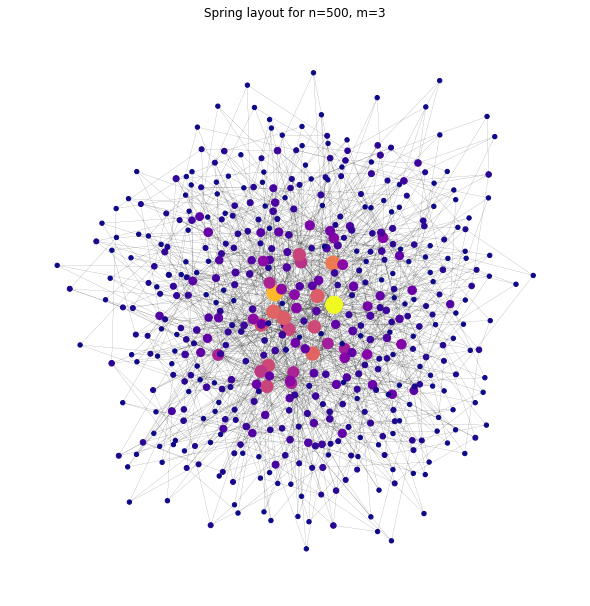

Elapsed 1.32 s


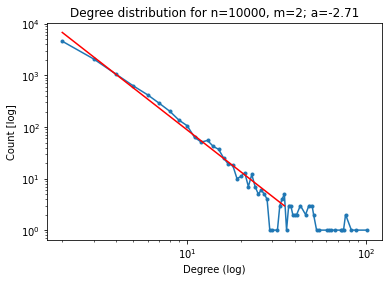

Elapsed 1.19 s


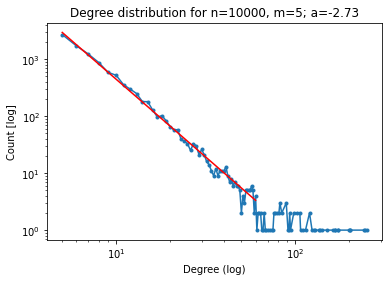

Elapsed 13.53 s


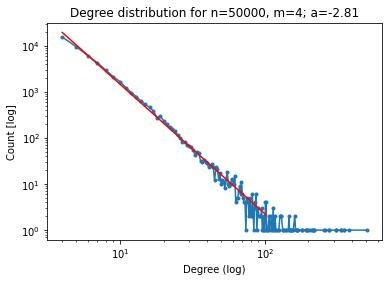

Elapsed 13.39 s


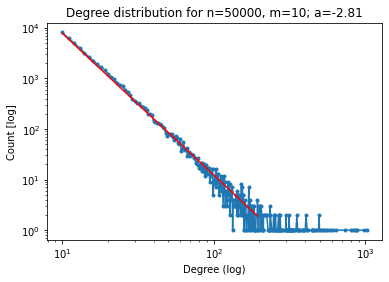

In [2]:
for n, m in [(100, 3), (500, 3), (10_000, 2), (10_000, 5), (50_000, 4), (50_000, 10)]:
    ba = BA(n, m, compute_adj=(n <= 1000))
    start = time.time()
    ba.build()
    print(f'Elapsed {time.time() - start:0.2f} s')
    degrees = ba.get_degrees()
    
    x, y = np.unique(degrees, return_counts=True)
    plt.loglog(x, y, marker='.')
    
    y_thresh = 2 if n <= 500 else 3
    
    x_fit, y_fit = np.log10(x)[y > y_thresh], np.log10(y)[y > y_thresh]
    a, b = np.polyfit(x_fit, y_fit, 1)
    plt.plot([10 ** x_fit[0], 10 ** x_fit[-1]], [10 ** (x_fit[0] * a + b), 10 ** (x_fit[-1] * a + b)] , c='red')
    
    plt.title(f'Degree distribution for n={n}, m={m}; a={a:0.2f}')
    plt.xlabel('Degree (log)')
    plt.ylabel('Count [log]')
    plt.show()
    
    if n <= 1000:
        G = nx.from_dict_of_lists(ba.adj)
        if n <= 100:
            sizes = 10 + 30 * ba.get_degrees()
            width = 0.3
        else:
            sizes = 1 + 6 * ba.get_degrees()
            width = 0.1
        colors = ba.get_degrees()
        
        plt.figure(figsize=(8, 8))
        nx.draw(G, pos=nx.kamada_kawai_layout(G), node_size=sizes, node_color=colors, width=width, cmap='plasma')
        plt.title(f'Kamanda-Kawai layout for n={n}, m={m}')
        plt.show()

        plt.figure(figsize=(8, 8))
        nx.draw(G, pos=nx.spring_layout(G), node_size=sizes, node_color=colors, width=width, cmap='plasma')
        plt.title(f'Spring layout for n={n}, m={m}')
        plt.show()

Zgodnie z oczekiwaniami, wartości wykładnika $a$ coraz bardziej zbliżają się do $-3$ zwiększając liczbę wierzchołków.

# Zadanie 2. Odporność grafu scale-free na błędy i ataki

Uwaga: współczynniki obliczam do momentu przekroczenia f = 60 %. Po przekroczeniu tej wartości w grafie zaczyna się dzielić na sporo spójnych składowych, przez co obliczanie odległości traci sens.

In [3]:
N, M = 300, 4

In [4]:
def average_shortest_path_length(G: nx.classes.graph.Graph):
    d = dict(nx.shortest_path_length(G))
    n = len(d)
    return sum([sum(d_u.values()) for d_u in d.values()]) / (n * (n - 1))

def calculate_attack_stats(ba: BARemover):
    f = []
    eff = []
    avg_len = []
    
    while ba.adj:
        f_this = (N - len(ba.adj)) / N * 100
        if f_this > 60:
            break
        f.append(f_this)

        G = nx.from_dict_of_lists(ba.adj)
        eff.append(nx.global_efficiency(G))
        avg_len.append(average_shortest_path_length(G))

        ba.remove_vertex()
        
    return f, eff, avg_len

In [5]:
ba = BARemover(N, M, remove_mode='random')
ba.build()
f_1, eff_1, avg_len_1 = calculate_attack_stats(ba)

ba = BARemover(N, M, remove_mode='attack')
ba.build()
f_2, eff_2, avg_len_2 = calculate_attack_stats(ba)

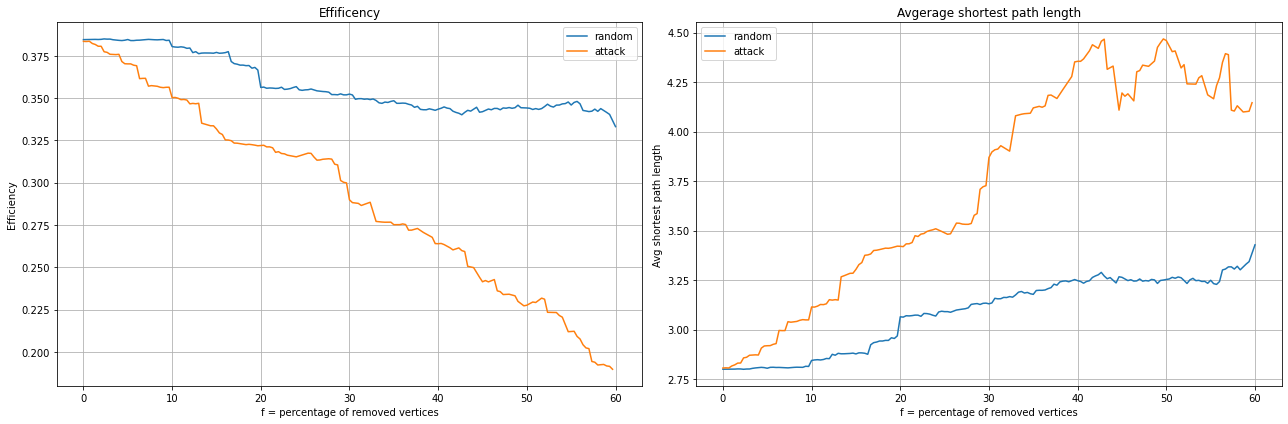

In [6]:
plt.figure(figsize=(18, 6))
    
plt.subplot(1, 2, 1)
plt.plot(f_1, eff_1, label='random')
plt.plot(f_2, eff_2, label='attack')
plt.grid()
plt.title('Effificency')
plt.xlabel('f = percentage of removed vertices')
plt.ylabel('Efficiency')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(f_1, avg_len_1, label='random')
plt.plot(f_2, avg_len_2, label='attack')
plt.grid()
plt.title('Avgerage shortest path length')
plt.xlabel('f = percentage of removed vertices')
plt.ylabel('Avg shortest path length')
plt.legend()

plt.tight_layout()

- Jak można się było domyślić, usuwanie wierzchołków z prawdopodobieństwem proporcjonalnym do ich stopnia ma znacznie większy wpływ na efektywność i średnią długość najkrótszej ścieżki od usuwania losowego. 
- Wcześniejsze usuwanie wierzchołków z dużą liczbą krawędzi (hubów) sprawia, że trzeba szukać dróg okrężnych, co zmniejsza efektywność i wydłuża ścieżki. 
- Z pomocą atakowania udało się osiągnąć wartości niemalże dwa razy większe (średnia długość) lub mniejsze (efektywność) w porównaniu do losowania wierzchołków do usunięcia.